In [1]:
import sys
sys.path.append("\..")

In [2]:
from lava.proc.lif.process import LIF
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.kernels.kernels import MultiPeakKernel
from lava.lib.dnf.operations.operations import Convolution
from lava.lib.dnf.kernels.kernels import SelectiveKernel
from lava.proc.io.source import RingBuffer

In [3]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen
from lava.proc.monitor.process import Monitor
import scipy.sparse


In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
points = np.load("slider_02.npy")
# gt = np.load("slider_02_gt.npy")
avg = np.load("slider_02_avg.npy")

In [6]:
points = points[::1]
points.shape

(5592,)

In [7]:
val_range=[0.0, 3.0]
n_levels = 300

In [8]:
input_data = np.zeros((points.shape[0], n_levels))

In [9]:
for i, p in enumerate(points):
    if np.isnan(p) or p<val_range[0] or p>=val_range[1]:
        continue
    idx = int((n_levels / val_range[1]) * p)
#     print(idx)
    input_data[i, idx] = 1 
# input_data = input_data.transpose()
print(input_data.shape)

(5592, 300)


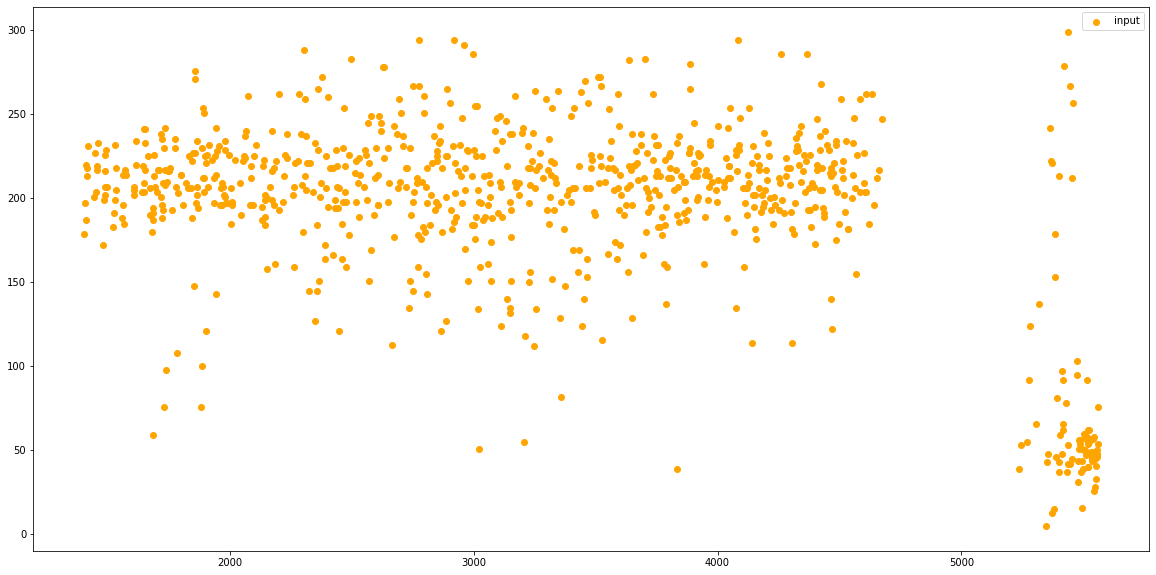

In [10]:

test = input_data
data_s = scipy.sparse.csr_matrix(test[:])

t_in, v_in, _ = scipy.sparse.find(data_s)

plt.figure(figsize=(20, 10))
plt.scatter(t_in, v_in, label="input", color="orange")
plt.legend()
# plt.axhline(20, c="red")
# plt.ylim([0, 300])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


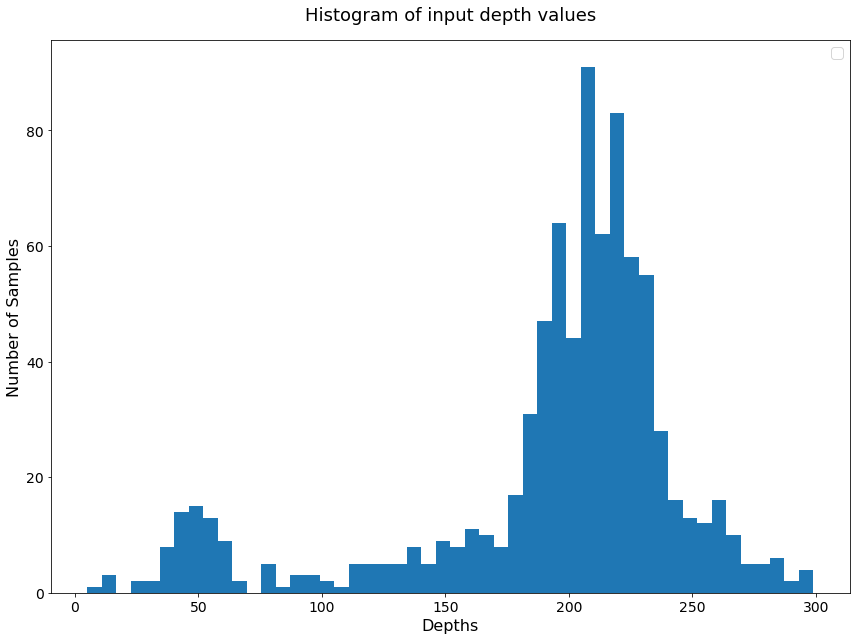

In [11]:
plt.figure(figsize=(12, 9))
plt.hist(v_in, 50);

plt.legend(fontsize=14)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel("Depths", fontsize=16)
plt.ylabel("Number of Samples", fontsize=16)
plt.title("Histogram of input depth values", fontsize=18, pad=20)

plt.tight_layout()

In [12]:
input_data = input_data.transpose()
input_data.shape

(300, 5592)

In [13]:
input_proc = RingBuffer(input_data)

In [14]:
dnf = LIF(shape=(n_levels,), du=0.12, dv=0.3, vth=10)

kernel = SelectiveKernel(amp_exc=4.0,
                         width_exc=10.0,
                         global_inh=-3)

connect(dnf.s_out, dnf.a_in, [Convolution(kernel)])
connect(input_proc.s_out, dnf.a_in, [Weights(10)])

In [15]:
# Set up a monitor and probe the spike output of the DNF
time_steps = points.shape[0]
monitor = Monitor()
monitor.probe(dnf.s_out, time_steps)

monitor_v = Monitor()
monitor_v.probe(dnf.v, time_steps)

monitor_u = Monitor()
monitor_u.probe(dnf.u, time_steps)

# Run the DNF
dnf.run(condition=RunSteps(num_steps=time_steps),
        run_cfg=Loihi1SimCfg(select_tag='floating_pt'))

# Get probed data from monitor
probed_data = monitor.get_data()
# probed_data_v = monitor_v.get_data()
# probed_data_u = monitor_u.get_data()

# Stop the execution after getting the monitor's data
dnf.stop()

In [16]:
data = probed_data[dnf.name][dnf.s_out.name]

In [17]:
probed_data

{'Process_1': {'s_out': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])}}

In [18]:
data.shape

(5592, 300)

In [19]:
probed_data

{'Process_1': {'s_out': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])}}

In [20]:
data_s = scipy.sparse.csr_matrix(data)

In [21]:
t_out, v_out, _ = scipy.sparse.find(data_s)

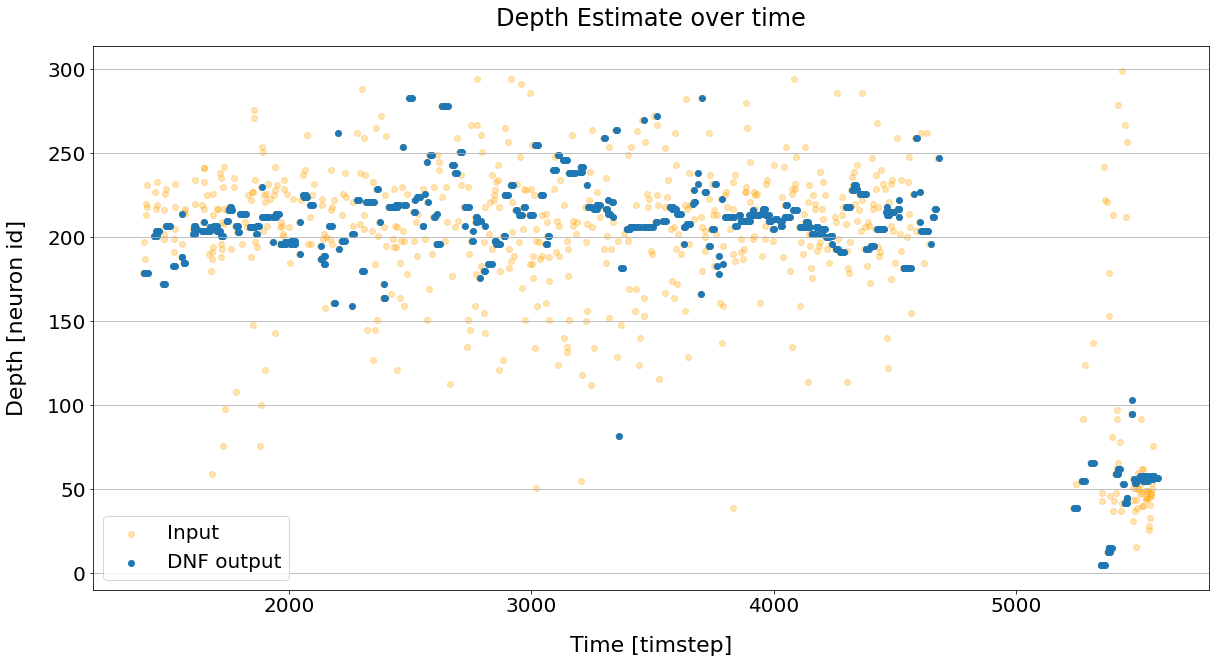

In [22]:
plt.figure(figsize=(20, 10))
plt.scatter(t_in, v_in, alpha=0.3, label="Input", color="orange")
plt.scatter(t_out, v_out, label="DNF output")
plt.xlabel("Time [timstep]", fontsize=22, labelpad=20)
plt.ylabel("Depth [neuron id]", fontsize=22, labelpad=20)
plt.title("Depth Estimate over time", fontsize=24, pad=20)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
# plt.ylim([100, 250])
# print(results.times[1226])
# plt.plot(gt[:, 0]*2000, gt[:, 1]*200, label="groundtruth", color="green")
plt.grid(axis="y")
# plt.plot(np.linspace(t_in.min(), t_in.max(), avg.shape[0]), avg*200, color="red", label="Average", alpha=0.5)
plt.legend(fontsize=20)


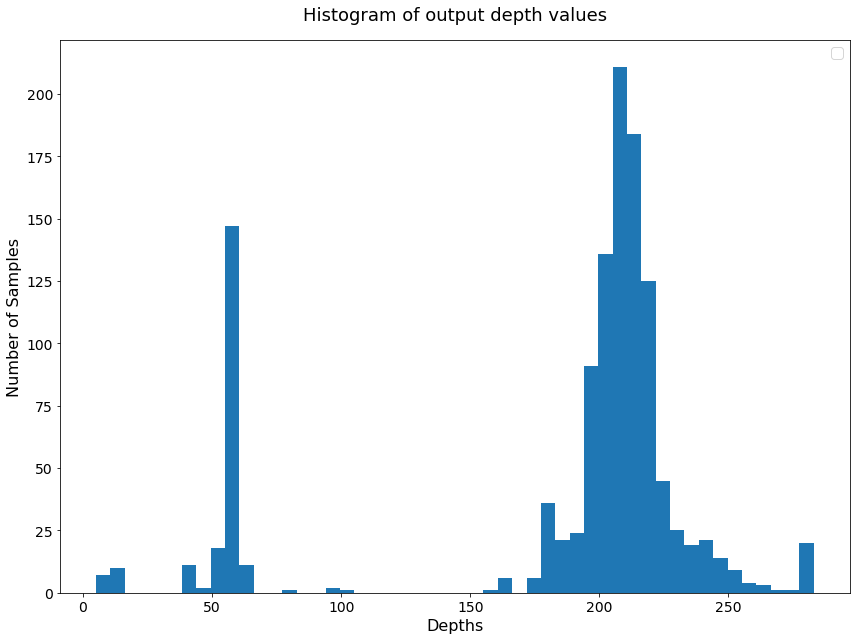

In [23]:
plt.figure(figsize=(12, 9))
plt.hist(v_out, 50);

plt.legend(fontsize=14)

plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel("Depths", fontsize=16)
plt.ylabel("Number of Samples", fontsize=16)
plt.title("Histogram of output depth values", fontsize=18, pad=20)

plt.tight_layout()

In [24]:
dnf_out = np.zeros((t_out.shape[0], 2))
dnf_out[:, 0] = t_out
dnf_out[:, 1] = v_out

gt_data = gt
gt_data[:, 0] = gt_data[:, 0] * 2000
gt_data[:, 1] = gt_data[:, 1] * 200

avg_out = np.zeros((avg.shape[0], 2))
avg_out[:, 0] = np.linspace(t_in.min(), t_in.max(), avg.shape[0])
avg_out[:, 1] = avg * 200

NameError: name 'gt' is not defined

In [ ]:
def error(data, gt):
    errors_list = []
    for t, v in data:
        idx = np.searchsorted(gt[:, 0], t)
        errors_list.append(np.abs(v - gt[idx, 1]))
    return np.array(errors_list)

In [ ]:
print("dnf:")
dnf_errors = error(dnf_out, gt_data)
print("mean error: {} \nmedian error: {}".format(np.mean(dnf_errors) / 200, np.median(dnf_errors) / 200))
print("Avg:")
avg_errors = error(avg_out, gt_data)
print("mean error: {} \nmedian error: {}".format(np.mean(avg_errors) / 200, np.median(avg_errors) / 200))

In [ ]:
# test = input_data.transpose()
# data_s = scipy.sparse.csr_matrix(test[:])

# t, v, _ = scipy.sparse.find(data_s)

# plt.figure(figsize=(20, 10))
# plt.scatter(t, v / 100)
# plt.axhline(2.0, c="red")
# plt.axhline(1.4, c="red")
# # plt.ylim([1.0, 2.5])

In [ ]:
np.linspace(t_in.min(), t_in.max(), avg.shape[0])

In [ ]:
probed_data_v

In [ ]:
data_v = probed_data_v["Process_1"]["v"]

In [ ]:
plt.plot(data_v[:, 180])

In [ ]:
data_v.shape

In [ ]:
data_u = probed_data_u["Process_1"]["u"]

In [ ]:
plt.plot(data_u[:, 180])

In [ ]:
kernel.weights

In [ ]:
plt.figure(figsize=(1, 20))
m = plt.imshow((kernel.weights.reshape(41, 1)))
plt.colorbar(m)

In [ ]:
data.shape

In [ ]:
np.save("line_top_03_res.npy", data)